## {insert names of team members}
*
*
*

In [1]:
# !uv pip list

In [2]:
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import Timer

In [3]:
num_cores = os.cpu_count()
print(num_cores)

8


# limit the total number of threads used with POLARS_MAX_THREADS
#### first, start with the default (commented out)
#### then, set it to 1

In [4]:
# os.environ['POLARS_MAX_THREADS'] = '1'  # kernel must be restarted to overwrite existing env variable

In [5]:
THREAD_COUNT = pl.thread_pool_size()
print(THREAD_COUNT)

8


# Generate dummy data

In [6]:
def generate_data(number_of_rows):
    rng = np.random.default_rng()

    return {
        "region": rng.choice(
            ["North", "South", "East", "West"], size=number_of_rows
        ),
        "sales_person": rng.choice(
            ["Armstrong", "Aldrin", "Collins"], size=number_of_rows
        ),
        "product": rng.choice(
            ["Helmet", "Oxygen", "Boots", "Gloves"], size=number_of_rows
        ),
        "sales_income": rng.integers(1, 5001, size=number_of_rows),
    }

# Define DataFrame Creation Functions

In [7]:
def create_pandas_dataframe(test_data):
    return pd.DataFrame(test_data)

def create_polars_dataframe(test_data):
    return pl.DataFrame(test_data)

def create_polars_lazyframe(test_data):
    return pl.LazyFrame(test_data)

# Display First 10 rows

In [8]:
display_data = generate_data(10)
create_pandas_dataframe(display_data)

,region,sales_person,product,sales_income
0,West,Collins,Helmet,3332
1,North,Collins,Oxygen,3455
2,East,Armstrong,Boots,2792
3,South,Aldrin,Oxygen,4174
4,South,Aldrin,Oxygen,363
5,South,Collins,Helmet,3224
6,North,Collins,Boots,93
7,West,Armstrong,Boots,4397
8,East,Collins,Boots,1174
9,South,Armstrong,Gloves,2105


# Define groupby & agg functions (can be parallelized)

In [9]:
def groupby_pandas_dataframe(pandas_df):
    return pandas_df.groupby(["region", "product", "sales_person"])[
        "sales_income"
    ].sum()

def groupby_polars_dataframe(polars_df):
    return polars_df.group_by(["region", "product", "sales_person"]).agg(
        total_sales=pl.col("sales_income").sum()
    )

def groupby_polars_lazyframe(polars_lf):
    return polars_lf.group_by(["region", "product", "sales_person"]).agg(
        total_sales=pl.col("sales_income").sum()
    ).collect()

## Insert a new operation to benchmark that can either:
### * also be parallelized (left size of classroom when facing front)
### * not be parallelized (right size of classroom when facing front)

In [10]:
# your code here

# Run Benchmarking 

In [11]:
# --- Benchmarking Loop ---
row_counts = [100_000, 1_000_000, 10_000_000]
results = []
n_runs = 10  # Number of times to repeat the timing for a stable average

print("Starting benchmark...")
for rows in row_counts:
    print(f"Benchmarking with {rows:,} rows...")
    test_data = generate_data(rows)

    # --- Pandas Benchmark ---
    pandas_df = pd.DataFrame(test_data)
    size_bytes = pandas_df.memory_usage(index=True).sum()
    size_mb = size_bytes / (1024 ** 2)
    print(f"Pandas DataFrame size: {size_mb:.2f} MB")
    
    pandas_groupby_time = np.mean(Timer(lambda: groupby_pandas_dataframe(pandas_df)).repeat(repeat=n_runs, number=1))
    results.append({"Library": "Pandas", "Operation": "GroupBy", "Rows": rows, "MeanTime": pandas_groupby_time})

    # add code to call new operation here
    
    # --- Polars Eager Benchmark ---
    polars_df = pl.DataFrame(test_data)
    size_bytes = polars_df.estimated_size()
    size_mb = size_bytes / (1024 ** 2)
    print(f"Polars Eager DataFrame size: {size_mb:.2f} MB")
    
    polars_eager_groupby_time = np.mean(Timer(lambda: groupby_polars_dataframe(polars_df)).repeat(repeat=n_runs, number=1))
    results.append({"Library": "Polars Eagar", "Operation": "GroupBy", "Rows": rows, "MeanTime": polars_eager_groupby_time})

    # add code to call new operation here

    # --- Polars LazyFrame Benchmark ---
    polars_lf = pl.LazyFrame(test_data)
    polars_lf_groupby_time = np.mean(Timer(lambda: groupby_polars_lazyframe(polars_lf)).repeat(repeat=n_runs, number=1))
    results.append({"Library": "Polars LazyFrame", "Operation": "GroupBy", "Rows": rows, "MeanTime": polars_lf_groupby_time})

    # add code to call new operation here

    print("-----------")
print("Benchmark finished.")
results_df = pd.DataFrame(results)


Starting benchmark...
Benchmarking with 100,000 rows...
Pandas DataFrame size: 3.05 MB
Polars Eager DataFrame size: 2.44 MB
-----------
Benchmarking with 1,000,000 rows...
Pandas DataFrame size: 30.52 MB
Polars Eager DataFrame size: 24.40 MB
-----------
Benchmarking with 10,000,000 rows...
Pandas DataFrame size: 305.18 MB
Polars Eager DataFrame size: 243.98 MB
-----------
Benchmark finished.


In [12]:
results_df

,Library,Operation,Rows,MeanTime
0,Pandas,GroupBy,100000,0.010741
1,Polars Eagar,GroupBy,100000,0.003816
2,Polars LazyFrame,GroupBy,100000,0.001915
3,Pandas,GroupBy,1000000,0.107789
4,Polars Eagar,GroupBy,1000000,0.014034
5,Polars LazyFrame,GroupBy,1000000,0.014061
6,Pandas,GroupBy,10000000,2.003312
7,Polars Eagar,GroupBy,10000000,0.282951
8,Polars LazyFrame,GroupBy,10000000,0.227520


## Bar Plot

file saved to benchmarking_groupby_8threads.png


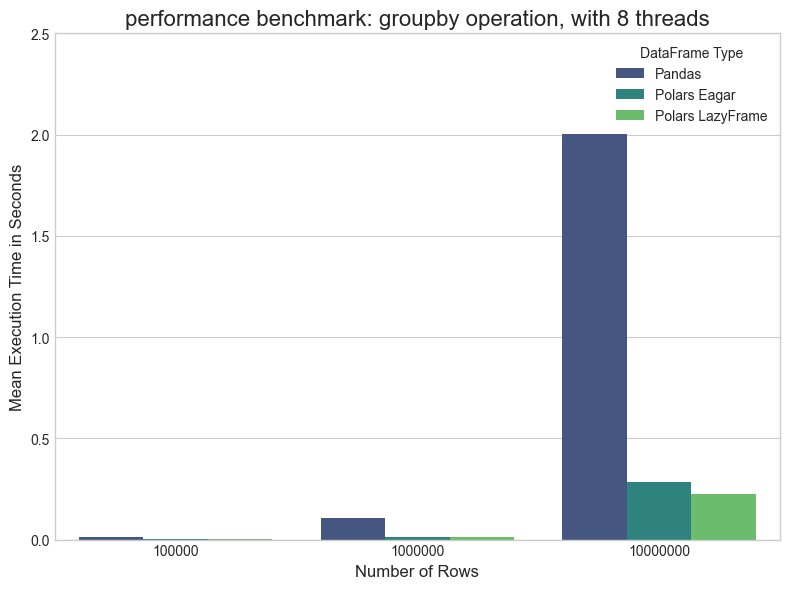

In [13]:
def plot_benchmarks(df, operation_name, thread_count):
    """Creates and saves a bar plot of the benchmark results."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6))

    op_df = df[df["Operation"] == operation_name]
    op_df['Rows_Category'] = op_df['Rows'].astype(str)

    sns.barplot(
        data=op_df,
        x="Rows_Category",
        y="MeanTime",
        hue="Library",
        ax=ax,
        palette="viridis",
        errorbar=None
    )

    ax.set_title(f"performance benchmark: {operation_name.lower()} operation, with {thread_count} threads", fontsize=16)
    ax.set_xlabel("Number of Rows", fontsize=12)
    ax.set_ylabel("Mean Execution Time in Seconds", fontsize=12)
    ax.grid(True, axis="x", which="minor", ls="--")
    ax.set_ylim([0, 2.5])
    plt.legend(title="DataFrame Type")
    plt.tight_layout()
    plt.savefig(f"benchmarking_{operation_name.lower()}_{thread_count}threads.png")
    print(f"file saved to benchmarking_{operation_name.lower()}_{thread_count}threads.png")

# Create and save the plot
plot_benchmarks(
    df=results_df,
    operation_name="GroupBy",
    thread_count=THREAD_COUNT,
)

## create plot for your new operation:
# plot_benchmarks(
#     df=results_df,
#     operation_name="blah",
#     thread_count=THREAD_COUNT,
# )